<a href="https://colab.research.google.com/github/neginsh/Deep-Learning-und-Textanalyse-in-Finance/blob/main/Project_Assignment_2_Negin_Shademan_109731.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Please use the following data set: https://raw.githubusercontent.com/RalfKellner/data_transfer/main/sp500_alltimers.csv

- Please send an E-Mail to lukas.marx@uni-passau in order to receive your personal data timeline.
- Import and prepare the data as you are used to
- Build a small Autoencoder with an Encoder output dimension of 3
- Take a look at the top 10 and lowest 10 in terms of square root of squared errors, plot their normalized returns (each close price divided by the first close price) over the whole time period and calculate the correlation, what do you see ? 
- Build several different Autoencoder with 3,5,8,11 Encoder output dimensions, both linear and non-linear (therefore 8 in Total).
- Compare the constiuants of top 40 and lowest 40 companies in terms of square root of squared erros (for comparison calculate the percentage of matching companies). 
- Send your solution to lukas.marx@uni-passau.de

Deadline: 01.02.2023 2pm (14:00) 


Negin Shademan

Matrikelnummer:
109731


---

Training 2010-2011

Validation 2012



# Loading the data and importing necessary libraries

In [ ]:
import numpy as np
import pandas as pd
import pylab as pl
from matplotlib import pyplot as plt
import scipy.stats as scs
from scipy.stats import zscore
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import datetime
from dateutil.relativedelta import relativedelta

from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, r2_score, mean_absolute_error as mae
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf


In [ ]:
url = 'https://raw.githubusercontent.com/RalfKellner/data_transfer/main/sp500_alltimers.csv'
df = pd.read_csv(url, parse_dates=["date"])
df.set_index(pd.to_datetime(df.date), inplace = True)
df.drop(['date'], axis = 1, inplace = True)
df.head()

,AAPL,ABT,ADBE,ADM,ADP,ADSK,AEE,AEP,AIG,ALL,...,WFC,WHR,WM,WMB,WMT,WRK,WY,XEL,XOM,YUM
date,,,,,,,,,,,,,,,,,,,,,
1998-01-02,0.123676,8.664290,4.9977,10.592284,14.556592,8.9131,13.007511,16.675596,493.513336,25.293035,...,9.802009,28.258766,22.608261,9.080934,12.959832,NaN,7.992623,9.964503,14.441016,3.740663
1998-01-05,0.120823,8.712471,5.0671,10.622808,14.753723,9.0913,12.912563,16.614594,490.152191,24.946089,...,9.705754,28.684456,22.389481,9.239215,13.083271,NaN,8.105922,9.878420,14.280560,3.628285
1998-01-06,0.144131,8.567928,5.2368,10.378607,14.784045,9.3587,12.722677,16.573921,488.191773,24.685869,...,9.609494,28.946413,22.644733,9.041370,13.165551,NaN,8.085321,9.738531,13.770018,3.475768
1998-01-07,0.133190,8.624138,5.1597,11.019638,14.586929,9.0457,12.608740,16.512913,483.429932,24.703232,...,9.449069,28.193266,22.498867,8.843530,13.124411,NaN,7.817531,9.641684,14.207628,3.467741
1998-01-08,0.138423,8.736559,5.2060,10.958587,14.526262,9.2540,12.456830,16.553585,480.909332,24.460360,...,9.609494,28.356985,21.878969,8.645684,12.939268,NaN,7.570335,9.663206,13.901303,3.331276


# Preprocessing

If we take a close look at our data we can see that 5 companies in the dataset are missing values. Therefore, we will remove them from our dataset. This leaves us with 188 companies. Next, we will normalize our data. For this assignment, 2010 to 2011 was chosen for training data and 2012 for our validation data. If we look at the box plot for training data, we can see that some companies have outliers. These outliers can be due to a not anticipated change in closing price.

In [ ]:
df.columns[df.isnull().sum() > 0]

Index(['MET', 'PARA', 'SRE', 'TPR', 'WRK'], dtype='object')

In [ ]:
df = df.drop( df.columns[df.isnull().sum() > 0], axis = 1)

In [ ]:
df.columns.shape

(188,)

In [ ]:
train_start = datetime.datetime(2010, 1, 1)
train_end = datetime.datetime(2011, 12, 31)
validation_start = datetime.datetime(2012, 1, 1)
validation_end = datetime.datetime(2012, 12, 31)
train = df.loc[train_start:train_end, :]
validation = df.loc[validation_start:validation_end, :]

In [ ]:
scaler = MinMaxScaler()
scaler.fit(train)
train_s, validation_s = scaler.transform(train), scaler.transform(validation)

In [ ]:
train_s_df = pd.DataFrame(train_s, columns = train.columns, index = train.index)
validation_s_df = pd.DataFrame(validation_s, columns = validation.columns, index = validation.index)

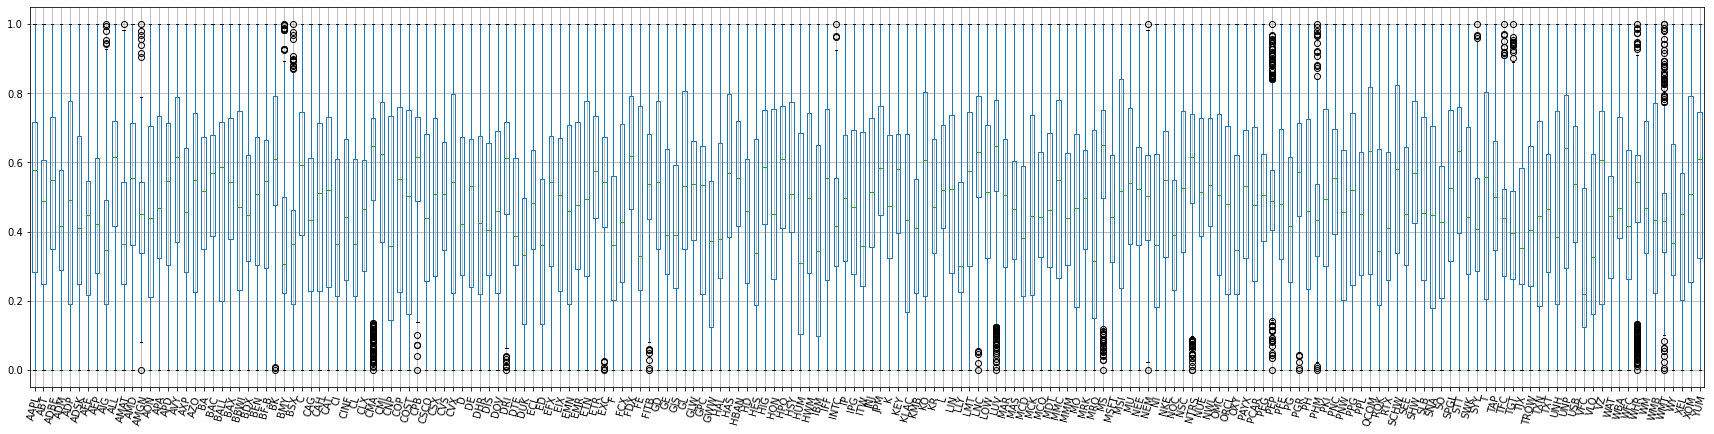

In [ ]:
train_s_df.boxplot(figsize = (30, 7), rot = 75)

# Autoencoder with encoder output 3 linear

First, we will train an autoencoder with an encoder output dimension of 3. In order to avoid overfitting we use a callback that controls validation loss and if it's not changing it will stop the training process.

In [ ]:
# dimension of latent representation
n_hidden = 3

# define a linear autoencoder
encoder = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape = (train_s.shape[1])),
    tf.keras.layers.Dense(n_hidden)
])

decoder = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape = (n_hidden)),
    tf.keras.layers.Dense(train_s.shape[1])
])

# define autoencoder with mean squared error as recreation loss
autoencoder = tf.keras.Sequential([encoder, decoder])
autoencoder.compile(loss = 'mse', optimizer = 'Adam')

# stop training data if mse for validation does not get better
my_callback = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 3)
fit_autoencoder = autoencoder.fit(train_s, train_s, epochs = 500, callbacks = [my_callback], validation_data = (validation_s, validation_s))

Epoch 1/500
16/16 [==============================] - 2s 46ms/step - loss: 0.2908 - val_loss: 0.8753
Epoch 2/500
16/16 [==============================] - 0s 18ms/step - loss: 0.2505 - val_loss: 0.7414
Epoch 3/500
16/16 [==============================] - 0s 9ms/step - loss: 0.1948 - val_loss: 0.5768
Epoch 4/500
16/16 [==============================] - 0s 13ms/step - loss: 0.1382 - val_loss: 0.4339
Epoch 5/500
16/16 [==============================] - 0s 15ms/step - loss: 0.0950 - val_loss: 0.3351
Epoch 6/500
16/16 [==============================] - 0s 12ms/step - loss: 0.0662 - val_loss: 0.2757
Epoch 7/500
16/16 [==============================] - 0s 16ms/step - loss: 0.0503 - val_loss: 0.2375
Epoch 8/500
16/16 [==============================] - 0s 12ms/step - loss: 0.0421 - val_loss: 0.2164
Epoch 9/500
16/16 [==============================] - 0s 13ms/step - loss: 0.0382 - val_loss: 0.2034
Epoch 10/500
16/16 [==============================] - 0s 16ms/step - loss: 0.0363 - val_loss: 0.1950


In [ ]:
# recreation of data
train_hat = autoencoder.predict(train_s)
validation_hat = autoencoder.predict(validation_s)

# differences of original data and recreations
Error_train = (train_s - train_hat)
Error_val = (validation_s - validation_hat)

error_train = pd.DataFrame(Error_train, columns = train.columns, index = train.index)
error_val = pd.DataFrame(Error_val, columns = validation.columns, index = validation.index)


# square root of squared errors
error_train_rsq = error_train.apply(lambda x: np.sqrt(x**2))
error_val_rsq = error_val.apply(lambda x: np.sqrt(x**2))

# avereage error per day
error_per_day_train = error_train_rsq.mean(axis = 1)
error_per_day_val = error_val_rsq.mean(axis = 1)
# average error per company
error_per_company_train = error_train_rsq.mean(axis = 0)
error_per_company_val = error_val_rsq.mean(axis = 0)

total_variation_train = train_s_df.apply(lambda x: x**2).sum().sum()
error_variation_train = error_train.apply(lambda x: x**2).sum().sum()
explained_variation_train = 1 - error_variation_train / total_variation_train

total_variation_val = validation_s_df.apply(lambda x: x**2).sum().sum()
error_variation_val = error_val.apply(lambda x: x**2).sum().sum()
explained_variation_val = 1 - error_variation_val / total_variation_val

factors_train, factors_val = encoder.predict(train_s), encoder.predict(validation_hat)
factors_train_df, factors_val_df = pd.DataFrame(factors_train, index = train.index), pd.DataFrame(factors_val, index = validation.index)

print(f'Explained variation of the autoencoder for training data: {explained_variation_train:.2f}')
print(f'Explained variation of the autoencoder for test data: {explained_variation_val:.2f}')

8/8 [==============================] - 0s 3ms/step
Explained variation of the autoencoder for training data: 0.95
Explained variation of the autoencoder for test data: 0.86




We can see based on the following graphs, that the daily error of our validation data is higher than training. Additionally, even though in our training data, we seem to have sudden big increases and decreases, the model has been able to capture them with the 3 variables pretty well because the error for every day is almost stable and without changes.



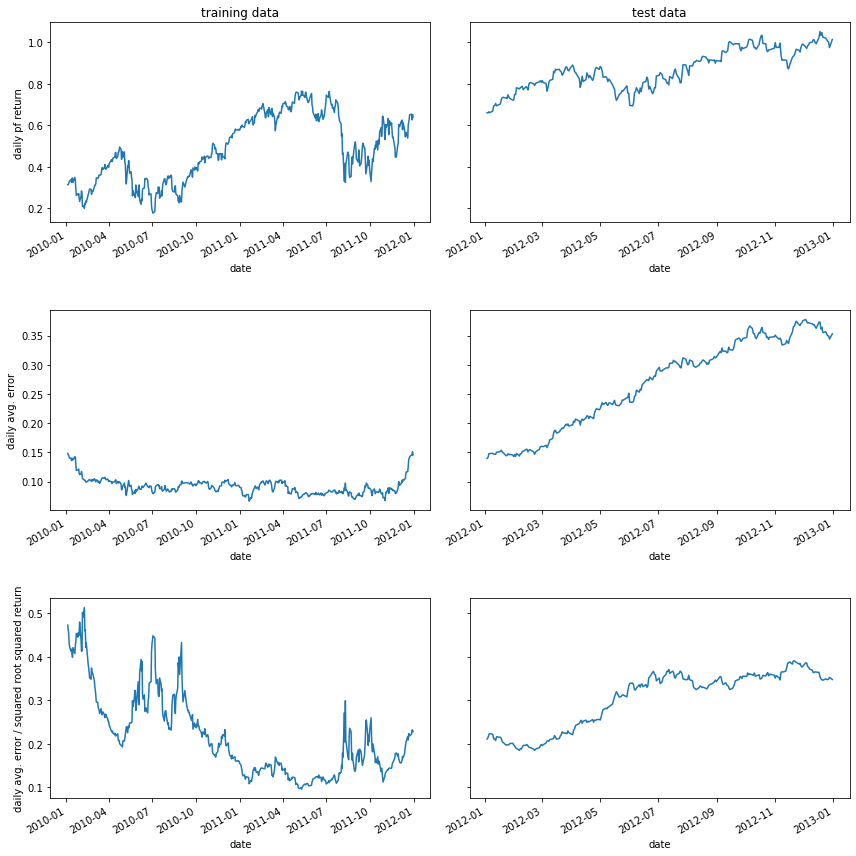

In [ ]:
fig, axs = plt.subplots(3, 2, figsize = (12, 12), sharey = 'row')
train_s_df.mean(axis = 1).plot(ax = axs[0, 0])
validation_s_df.mean(axis = 1).plot(ax = axs[0, 1])
error_per_day_train.plot(ax = axs[1, 0])
error_per_day_val.plot(ax = axs[1, 1])
(error_per_day_train / train_s_df.mean(axis = 1).apply(lambda x: np.sqrt(x**2))).plot(ax = axs[2, 0])
(error_per_day_val / validation_s_df.mean(axis = 1).apply(lambda x: np.sqrt(x**2))).plot(ax = axs[2, 1])
axs[0, 0].set_title('training data')
axs[0, 1].set_title('validation data')
axs[0, 0].set_ylabel('daily pf return')
axs[1, 0].set_ylabel('daily avg. error')
axs[2, 0].set_ylabel('daily avg. error / squared root squared return')
fig.tight_layout()

In the following graphs, it is apperent that the model works better for some of the companies. The companies that have higher recreation error probably are not very systamatic and are less coreelated to the market. we can also see a positive correllation for errors of train and test. 

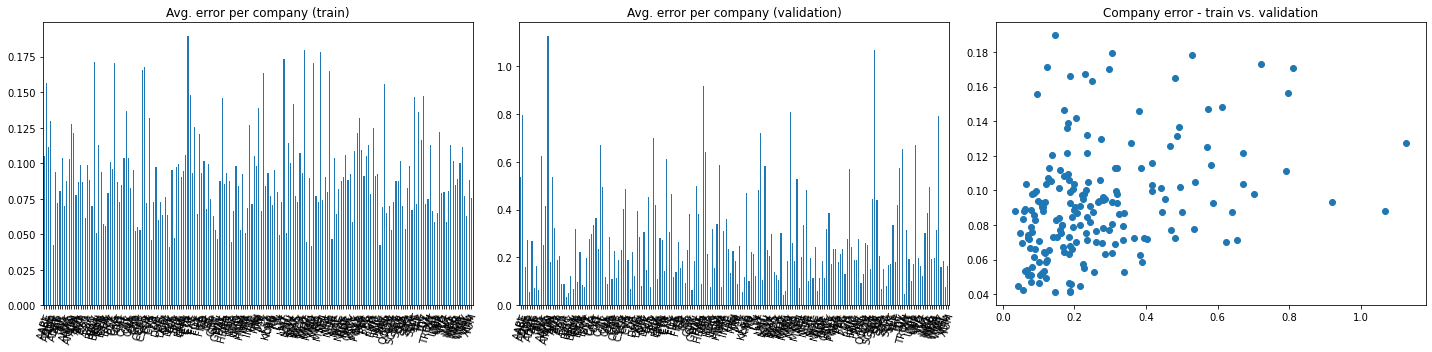

In [ ]:
fig, axs = plt.subplots(1, 3, figsize = (20, 5))
error_per_company_train.plot(kind = 'bar', rot = 75, ax = axs[0])
error_per_company_val.plot(kind = 'bar', rot = 75, ax = axs[1])
axs[2].scatter(error_per_company_val, error_per_company_train)
axs[0].set_title('Avg. error per company (train)')
axs[1].set_title('Avg. error per company (validation)')
axs[2].set_title('Company error - train vs. validation')
fig.tight_layout()

Down bellow, you can see the top 10 most and least square root of squared errors

In [ ]:
error_per_company_val.sort_values()[:10]

BAC     0.035428
MMC     0.042820
TROW    0.046774
BALL    0.052877
KEY     0.055594
ADP     0.056522
NTRS    0.058832
MMM     0.061299
GPC     0.061776
AIG     0.064599
dtype: float64

In [ ]:
error_per_company_val.sort_values()[-10:]

CINF    0.670300
USB     0.672094
EFX     0.701118
LMT     0.721948
WMT     0.790233
ABT     0.797353
MRK     0.809378
HD      0.918654
SHW     1.067903
AMGN    1.126558
dtype: float64

The top companies(least error) tend to be more similar to each other and correlated to the market and the lowest companies(most error) tend to have more ups and downs and sudden increase and decrease in their normalized return

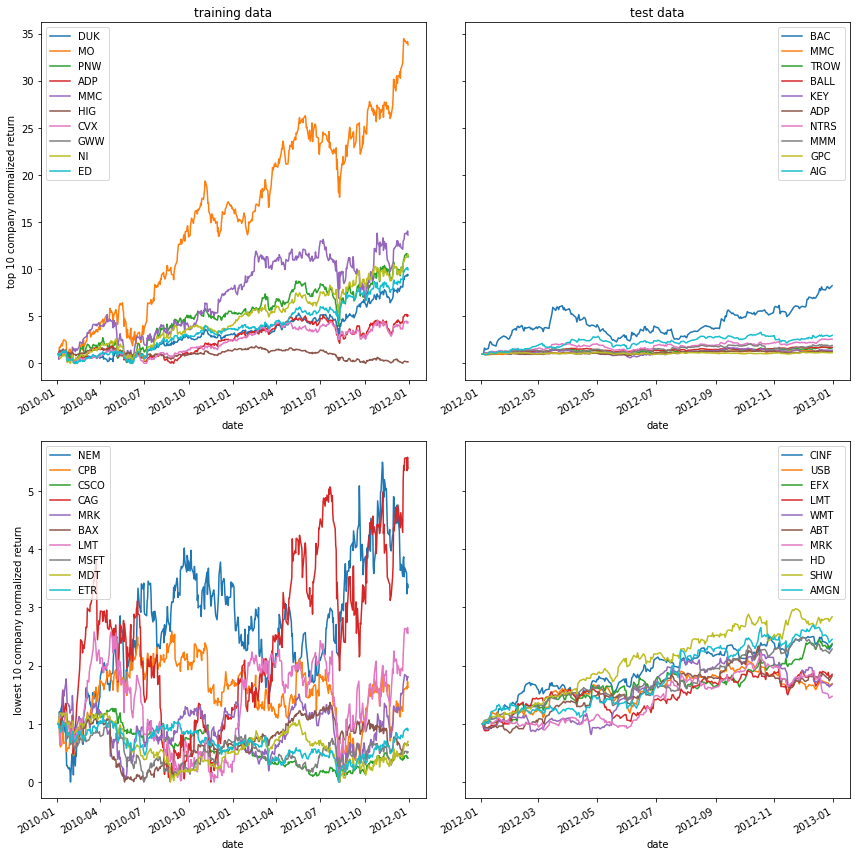

In [ ]:
# plot of normalized return 

# top_comp_val = validation_s[error_per_company_val.sort_values()[:10].index.tolist()]
norm_return_val = validation_s_df
norm_return_val = norm_return_val.divide(norm_return_val.iloc[0])


norm_return_train = train_s_df
norm_return_train = norm_return_train.divide(norm_return_train.iloc[0])

fig, axs = plt.subplots(2, 2, figsize = (12, 12), sharey = 'row')
norm_return_train[error_per_company_train.sort_values()[:10].index.tolist()].plot(ax = axs[0, 0])
norm_return_val[error_per_company_val.sort_values()[:10].index.tolist()].plot(ax = axs[0, 1])
norm_return_train[error_per_company_train.sort_values()[-10:].index.tolist()].plot(ax = axs[1, 0])
norm_return_val[error_per_company_val.sort_values()[-10:].index.tolist()].plot(ax = axs[1, 1])
axs[0, 0].set_title('training data')
axs[0, 1].set_title('test data')
axs[0, 0].set_ylabel('top 10 company normalized return')
axs[1, 0].set_ylabel('lowest 10 company normalized return')
fig.tight_layout()

In [ ]:
pd.concat((factors_train_df.corr(), factors_val_df.corr()), axis = 1)

,0,1,2,0,1,2
0,1.000000,-0.109062,0.947608,1.000000,0.778191,0.985023
1,-0.109062,1.000000,0.163792,0.778191,1.000000,0.872956
2,0.947608,0.163792,1.000000,0.985023,0.872956,1.000000


Based on the heatmaps for correlation of error for each company, we can see a either positive or negative big correlation between some of the companies. 

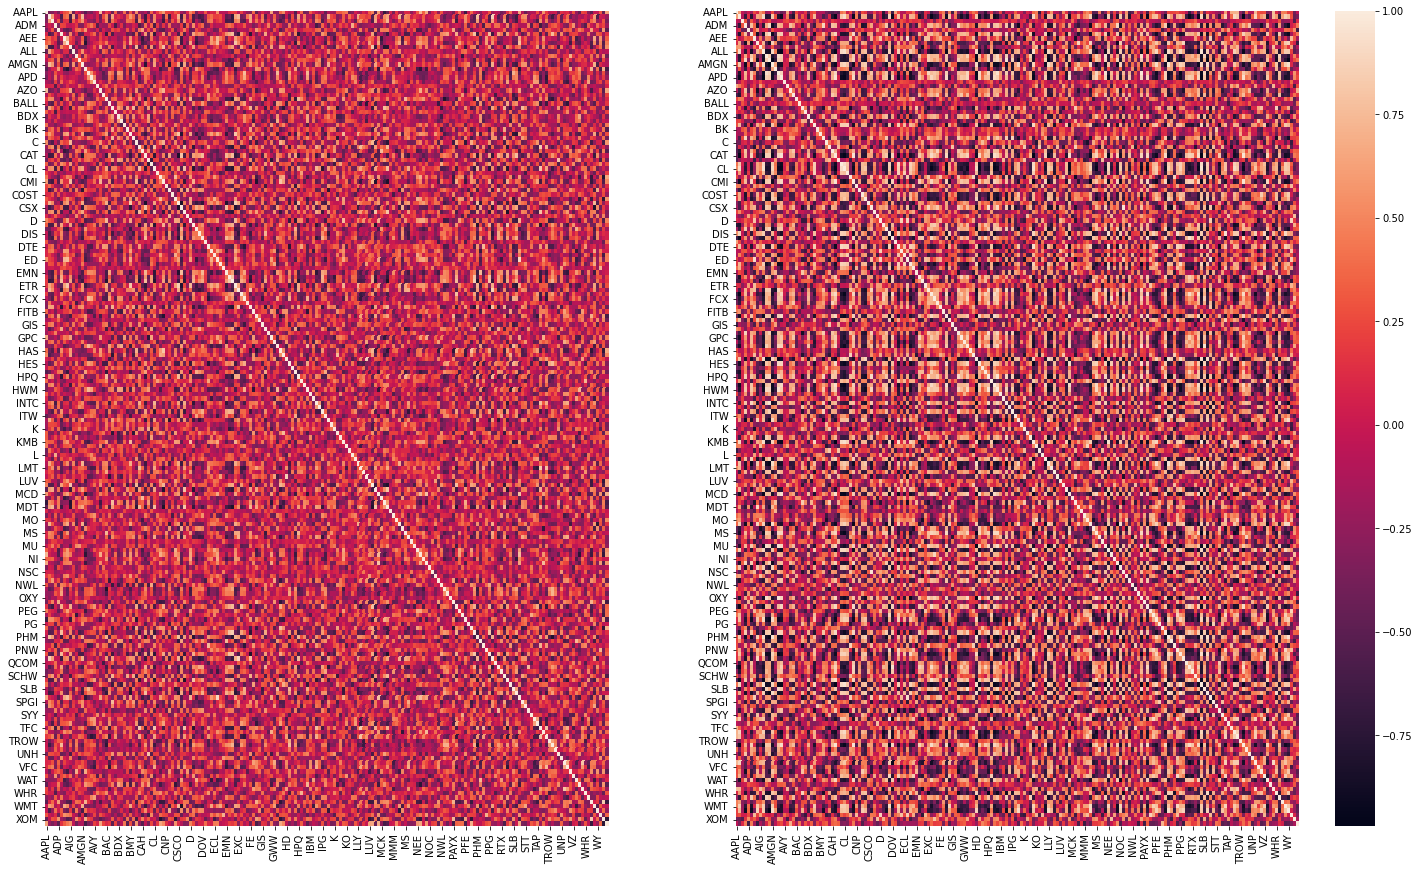

In [ ]:
# a heatmap with estimated correlation 
error_corr_train_df = pd.DataFrame(error_train).corr()
error_corr_val_df = pd.DataFrame(error_val).corr()

vmin = min(error_corr_train_df.values.min(), error_corr_val_df.values.min())
vmax = max(error_corr_train_df.values.max(), error_corr_val_df.values.max())

fig, axs = plt.subplots(1, 2, figsize = (25, 15), gridspec_kw=dict(width_ratios=[2,2.5]))
sns.heatmap(data = pd.DataFrame(error_train).corr(), ax = axs[0], vmin = vmin, vmax = vmax, cbar = False)
sns.heatmap(data = pd.DataFrame(error_val).corr(), ax = axs[1], vmin = vmin, vmax = vmax, cbar = True)

In [ ]:
avg_corr_train = train_s_df.corr().abs().values[np.tril_indices(error_corr_train_df.shape[0], k = -1)].mean()
avg_corr_test = validation_s_df.corr().abs().values[np.tril_indices(error_corr_val_df.shape[0], k = -1)].mean()
avg_res_corr_train = error_corr_train_df.abs().values[np.tril_indices(error_corr_train_df.shape[0], k = -1)].mean()
avg_res_corr_test = error_corr_val_df.abs().values[np.tril_indices(error_corr_val_df.shape[0], k = -1)].mean()
print(f'Average correlation training data: {avg_corr_train:.2f}')
print(f'Average correlation test data: {avg_corr_test:.2f}')
print(f'Average correlation left unexplained training data: {avg_res_corr_train:.2f}')
print(f'Average correlation left unexplained test data: {avg_res_corr_test:.2f}')

Average correlation training data: 0.51
Average correlation test data: 0.44
Average correlation left unexplained training data: 0.27
Average correlation left unexplained test data: 0.43


# comparison of different output dimensions and activation function

8 different autoencoders were trained using the same dataset. Based on the result of these autoencoder, we can see that the model with an output dimension of 8 and a linear activation function has the best explained variation for validation data. We also have 0 intersection(0/40 matching companies) between the top companies(least error). 3 companies(3/40 matching companies) had the most error for all of the models.

In [ ]:
autoencoders = {}

for n_hidden, activation in ((n,a) for n in [3,5,8,11] for a in ['linear','non-linear']):

  if activation == 'linear':

    encoder = tf.keras.Sequential([
        tf.keras.layers.InputLayer(input_shape = (train_s.shape[1])),
        tf.keras.layers.Dense(n_hidden)
    ])

    decoder = tf.keras.Sequential([
        tf.keras.layers.InputLayer(input_shape = (n_hidden)),
        tf.keras.layers.Dense(train_s.shape[1])
    ])

  else:
    encoder = tf.keras.Sequential([
       tf.keras.layers.InputLayer(input_shape = (train_s.shape[1])),
       tf.keras.layers.Dense(20, activation = 'relu'),
       tf.keras.layers.Dense(n_hidden)
    ])

    decoder = tf.keras.Sequential([
       tf.keras.layers.InputLayer(input_shape = (n_hidden)),
       tf.keras.layers.Dense(20, activation = 'relu'),
       tf.keras.layers.Dense(train_s.shape[1])
    ])

  # define autoencoder with mean squared error as recreation loss
  autoencoder = tf.keras.Sequential([encoder, decoder])
  autoencoder.compile(loss = 'mse', optimizer = 'Adam')

  # stop training data if mse for validation does not get better
  my_callback = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 3)
  print("{} autoencoder with {} encoder output dimension".format(activation,n_hidden))
  fit_autoencoder = autoencoder.fit(train_s, train_s, epochs = 500, callbacks = [my_callback], validation_data = (validation_s, validation_s))
  autoencoders[(n_hidden,activation)] = autoencoder

linear autoencoder with 3 encoder output dimension
Epoch 1/500
16/16 [==============================] - 1s 14ms/step - loss: 0.2855 - val_loss: 0.8410
Epoch 2/500
16/16 [==============================] - 0s 5ms/step - loss: 0.2424 - val_loss: 0.7045
Epoch 3/500
16/16 [==============================] - 0s 5ms/step - loss: 0.1903 - val_loss: 0.5490
Epoch 4/500
16/16 [==============================] - 0s 5ms/step - loss: 0.1401 - val_loss: 0.4162
Epoch 5/500
16/16 [==============================] - 0s 5ms/step - loss: 0.0996 - val_loss: 0.3222
Epoch 6/500
16/16 [==============================] - 0s 5ms/step - loss: 0.0721 - val_loss: 0.2628
Epoch 7/500
16/16 [==============================] - 0s 5ms/step - loss: 0.0556 - val_loss: 0.2265
Epoch 8/500
16/16 [==============================] - 0s 5ms/step - loss: 0.0460 - val_loss: 0.2056
Epoch 9/500
16/16 [==============================] - 0s 5ms/step - loss: 0.0407 - val_loss: 0.1900
Epoch 10/500
16/16 [==============================] - 0s 

In [ ]:
top_errors_per_company_val = []
top_company = []
bottom_company = []
bottom_errors_per_company_val = []
for autoencoder in autoencoders.values():

  # recreation of data
  validation_hat = autoencoder.predict(validation_s)

  # differences of original data and recreations
  Error_val = (validation_s - validation_hat)

  error_val = pd.DataFrame(Error_val, columns = validation.columns, index = validation.index)


  # square root of squared errors
  error_val_rsq = error_val.apply(lambda x: np.sqrt(x**2))

  # avereage error per day
  error_per_day_val = error_val_rsq.mean(axis = 1)
  # average error per company
  error_per_company_val = error_val_rsq.mean(axis = 0)
  top_errors_per_company_val.append(error_per_company_val.sort_values()[:10])
  top_company.append(error_per_company_val.sort_values()[:10].index.tolist())
  bottom_company.append(error_per_company_val.sort_values()[-10:].index.tolist())
  bottom_errors_per_company_val.append(error_per_company_val.sort_values()[-10:])

8/8 [==============================] - 0s 3ms/step


In [ ]:
set.intersection(*map(set,top_company))

set()

In [ ]:
set.intersection(*map(set,bottom_company))

{'AMGN', 'EXC', 'SHW'}

In [ ]:
top_errors_per_company_val

[MMM     0.050016
 BAC     0.054066
 ADP     0.057513
 NI      0.058716
 AIG     0.073392
 UNP     0.081523
 BK      0.082790
 TROW    0.084025
 AEE     0.084572
 HBAN    0.085319
 dtype: float64, BALL    0.049029
 BMY     0.049793
 MMC     0.050595
 COP     0.054286
 PH      0.061213
 GPC     0.062958
 ADBE    0.068434
 IBM     0.069142
 XOM     0.069620
 KEY     0.070038
 dtype: float64, NI      0.052995
 DHR     0.053150
 TROW    0.055085
 SO      0.063851
 DE      0.067235
 XEL     0.067647
 BBWI    0.068311
 MMC     0.070220
 GPC     0.071346
 C       0.073136
 dtype: float64, BAC     0.037844
 NI      0.044883
 UNP     0.049325
 TROW    0.051091
 KEY     0.053140
 XEL     0.055191
 SO      0.059525
 MMM     0.059907
 BK      0.069495
 BMY     0.071221
 dtype: float64, DHR     0.041351
 HON     0.042726
 AMAT    0.053537
 LNC     0.054303
 GPC     0.059956
 XOM     0.065012
 SEE     0.066155
 MU      0.068537
 BBWI    0.068963
 QCOM    0.070243
 dtype: float64, BAC     0.031129
 S

8/8 [==============================] - 0s 3ms/step
Explained variation of the autoencoder for test data: 0.85 for autoencoder with 3 output dimension and linear activation function
8/8 [==============================] - 0s 2ms/step
Explained variation of the autoencoder for test data: 0.88 for autoencoder with 3 output dimension and non-linear activation function
8/8 [==============================] - 0s 5ms/step
Explained variation of the autoencoder for test data: 0.88 for autoencoder with 5 output dimension and linear activation function
8/8 [==============================] - 0s 2ms/step
Explained variation of the autoencoder for test data: 0.87 for autoencoder with 5 output dimension and non-linear activation function
8/8 [==============================] - 0s 2ms/step
Explained variation of the autoencoder for test data: 0.90 for autoencoder with 8 output dimension and linear activation function
8/8 [==============================] - 0s 2ms/step
Explained variation of the autoencod

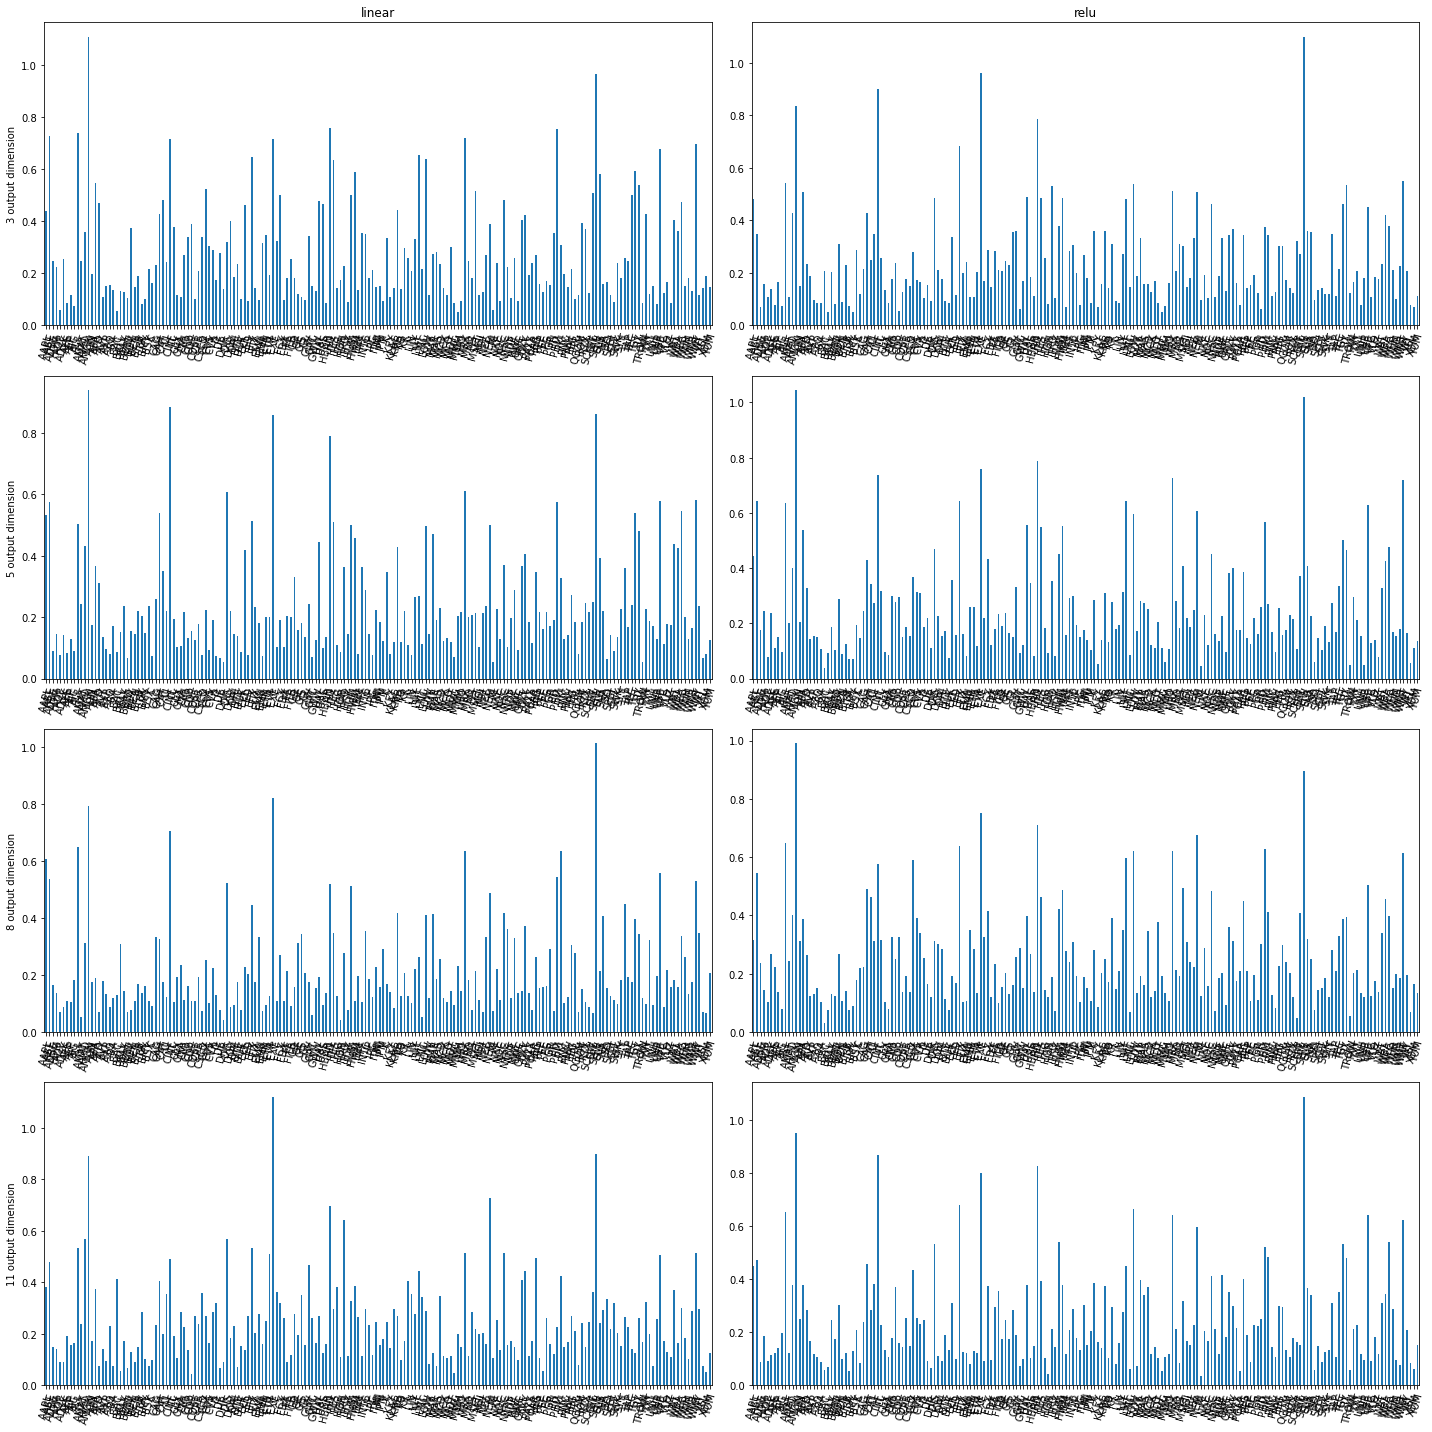

In [ ]:

fig, axs = plt.subplots(4, 2, figsize = (20, 20))
i = 0
for (n_hidden,activation),autoencoder in autoencoders.items():
  
  # recreation of data
  validation_hat = autoencoder.predict(validation_s)

  # differences of original data and recreations
  Error_val = (validation_s - validation_hat)

  error_val = pd.DataFrame(Error_val, columns = validation.columns, index = validation.index)


  # square root of squared errors
  error_val_rsq = error_val.apply(lambda x: np.sqrt(x**2))

  # avereage error per day
  error_per_day_val = error_val_rsq.mean(axis = 1)
  # average error per company
  error_per_company_val = error_val_rsq.mean(axis = 0)
  j = 0 if activation == 'linear' else 1
  error_per_company_val.plot(kind = 'bar', rot = 75, ax = axs[int(i/2),j])
  i+=1
  

  total_variation_val = validation_s_df.apply(lambda x: x**2).sum().sum()
  error_variation_val = error_val.apply(lambda x: x**2).sum().sum()
  explained_variation_val = 1 - error_variation_val / total_variation_val

  print(f'Explained variation of the autoencoder for test data: {explained_variation_val:.2f} for autoencoder with {n_hidden} output dimension and {activation} activation function')



axs[0, 0].set_title('linear')
axs[0, 1].set_title('relu')
axs[0, 0].set_ylabel('3 output dimension')
axs[1, 0].set_ylabel('5 output dimension')
axs[2, 0].set_ylabel('8 output dimension')
axs[3, 0].set_ylabel('11 output dimension')
fig.tight_layout()